In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import global_params as G
plt.rcParams['figure.figsize'] = G.SMALL_FIG

In [3]:
import numpy as np
from scipy import linalg
from scipy import signal

np.set_printoptions(precision=4, suppress=True)

In [4]:
from utilities import db
from receiver import quantalph

from equalization import *

## Least Squares

In [5]:
m = 1000 # Num symbols
noise_std = 0. # Std deviation for AWGN
alphabet = np.array([-1, 1])
channel = np.array([0.5, 1, -0.6])

symbols = np.random.choice(alphabet, m)
noise = noise_std*np.random.randn(m)
received = signal.lfilter(channel, 1, symbols)  + noise

In [6]:
n = 3 # num taps = 1 + n
delay = 2

p = len(received) - delay # tx symbols to consider
R = linalg.toeplitz(received[np.arange(n, p)], received[np.arange(n, -1, -1)])
S = symbols[n-delay:p-delay] # Since this is a training sequence, it is known at receiver
f = linalg.inv(R.T@R)@R.T@S
Jmin = S.T@S - S.T@R@linalg.inv(R.T@R)@R.T@S
y = signal.lfilter(f, 1, received)
decisions = quantalph(y, alphabet)
err = 0.5*np.sum(np.abs(decisions[delay:] - symbols[:m-delay]))

print(f'Delay = {delay}, Jmin = {Jmin:.1f}, errors = {err}, equalizer = {f}')

Delay = 2, Jmin = 33.5, errors = 0.0, equalizer = [-0.2759  0.6576  0.3088  0.1435]


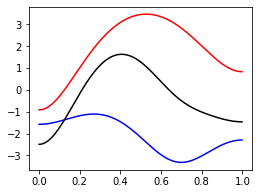

In [7]:
w, h_channel = signal.freqz(channel)
w, h_eq = signal.freqz(f)
w, h_combined = signal.freqz(np.convolve(channel, f))
plt.plot(w/np.pi, db(h_channel), 'r');
plt.plot(w/np.pi, db(h_eq), 'b');
plt.plot(w/np.pi, db(h_combined), 'k');

## LMS

In [8]:
n = 4 # num taps
mu = .01
delta = 2

f = np.zeros(n, float)
for i in range(n, len(received)):
    window = received[i:i-n:-1]
    predicted = np.dot(f, window)
    err = symbols[i-delta] - predicted
    f = f + mu*err*window
    
lms_eq = f
print(f'Final filter coeffs: {lms_eq}')

Final filter coeffs: [-0.273   0.668   0.3182  0.141 ]


In [9]:
# Implemented as a function
print(f'Filter coeffs from function: {lms_equalizer(received, symbols)}')

Filter coeffs from function: [-0.273   0.668   0.3182  0.141 ]


In [10]:
errors_vs_delay = evaluate_equalizer(channel, lms_eq, alphabet)
errors_vs_delay

array([510., 496.,   0., 495.])

## Decision directed Equalization

In [11]:
n = 4 # num taps
mu = .1

f = np.zeros(n, float)
f[len(f)//2] = 1 # Center-spike initialization
for i in range(n, len(received)):
    window = received[i:i-n:-1]
    predicted = np.dot(f, window)
    decision = quantalph(np.array(predicted), alphabet)
    err = decision[0] - predicted
    f = f + mu*err*window
    
dd_eq = f
print(f'Final filter coeffs: {dd_eq}')

Final filter coeffs: [ 0.0481 -0.3022  0.6377  0.2788]


In [12]:
# Implemented as a function
print(f'Filter coeffs from function: {dd_equalizer(received, alphabet)}')

Filter coeffs from function: [ 0.0481 -0.3022  0.6377  0.2788]


In [13]:
errors_vs_delay = evaluate_equalizer(channel, dd_eq, alphabet)
errors_vs_delay

array([498., 473., 485.,   0.])